# 2025Fall DSAA2011 Course Project — Covertype

**Course:** DSAA2011

**Group members:** Zehan Lu, Binkai Liu, Chi Kit WONG 

**Dataset:** UCI Forest CoverType (581,012 rows, 54 features, 7 classes)

## 0. Setup & Utilities
- Import common libraries.
- Define helper functions for plotting and evaluation.
- Set a global random seed for reproducibility.

In [1]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    adjusted_rand_score, normalized_mutual_info_score,
    fowlkes_mallows_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

sns.set_style("whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def plot_confusion(cm, labels, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def clustering_report(y_true, y_pred, X_embedded=None, title_prefix=""):
    scores = {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "FMI": fowlkes_mallows_score(y_true, y_pred),
    }
    # Internal metrics do not rely on ground truth
    scores["Silhouette"] = silhouette_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Calinski-Harabasz"] = calinski_harabasz_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Davies-Bouldin"] = davies_bouldin_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    print(f"\n{title_prefix} clustering metrics:")
    for k, v in scores.items():
        print(f"  {k:18s}: {v:.4f}")
    return scores

def plot_clusters_2d(X_2d, labels, title="Clusters", palette="tab10"):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette=palette,
                    s=10, linewidth=0, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.tight_layout()
    plt.show()

## 1. Data Preprocessing
**Goal:** load the Covertype data, handle missing/non-numeric fields, and standardize numeric features.

In [2]:
# 1.1 Load data
data_path = Path("data/covtype.data.gz")

continuous_cols = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]
column_names = continuous_cols + wilderness_cols + soil_cols + ["Cover_Type"]

df = pd.read_csv(data_path, header=None, names=column_names)
print(f"Loaded shape: {df.shape}")
df.head()

# 1.2 Basic checks
missing_total = df.isna().sum().sum()
print(f"Total missing values: {missing_total}")
if missing_total > 0:
    df = df.fillna(df.median(numeric_only=True))

# Convert target to int and keep label names
df["Cover_Type"] = df["Cover_Type"].astype(int)
label_map = {
    1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
    4: "Cottonwood/Willow", 5: "Aspen", 6: "Douglas-fir", 7: "Krummholz"
}

# 1.3 Train-test split
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
) # use stratify to maintain class distribution as the distribution of target classes is imbalanced

# 1.4 Standardize continuous features only (binary indicators stay as-is)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("Train/Test shapes:", X_train_scaled.shape, X_test_scaled.shape)

Loaded shape: (581012, 55)
Total missing values: 0
Train/Test shapes: (406708, 54) (174304, 54)


**Applied preprocessing steps:**
We first loaded the gzipped raw dataset from UCI and verified that no missing values were present, consistent with the dataset specification. The 44 binary indicator features for wilderness areas and soil types were preserved in their original 0/1 format, whereas the 10 continuous environmental variables were standardized using StandardScaler to ensure zero mean and unit variance. Train–test splitting was performed using a stratified sampling strategy (70%/30%) to preserve the original class proportions and prevent distributional shifts during evaluation.

**Observed data characteristics:**
The class distribution is strongly imbalanced, with the dominate Cover Type 1 and Cover Type 2 with several minority classes. The feature matrix combines dense continuous variables (e.g., elevation, distances, hillshade values) with sparse one-hot encoded categorical attributes representing wilderness and soil types. This feature structure and class imbalance indicate the need for careful model evaluation beyond accuracy and justify treating continuous and binary attributes differently during preprocessing.

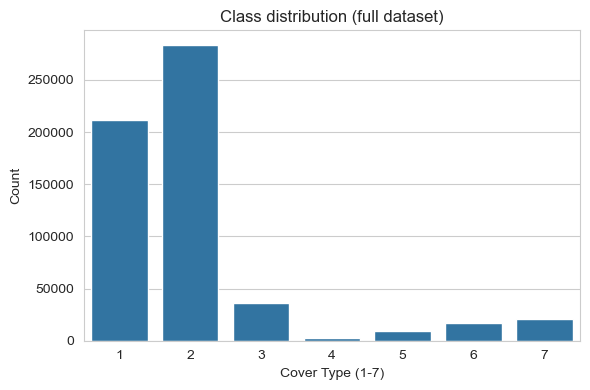

In [3]:
# Class balance visualization
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y, order=sorted(y.unique()), ax=ax)
ax.set_xlabel("Cover Type (1-7)")
ax.set_ylabel("Count")
ax.set_title("Class distribution (full dataset)")
plt.tight_layout()
plt.show()

## 2. Visualization (t-SNE)
**Goal:** project high-dimensional data into 2D using t-SNE and inspect cluster patterns by label.

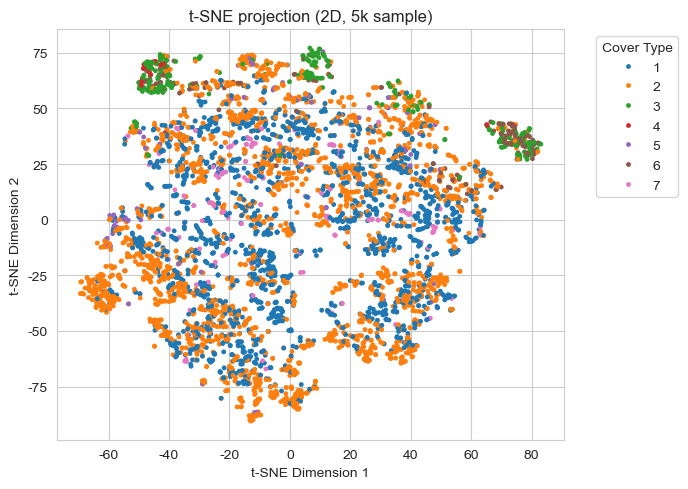

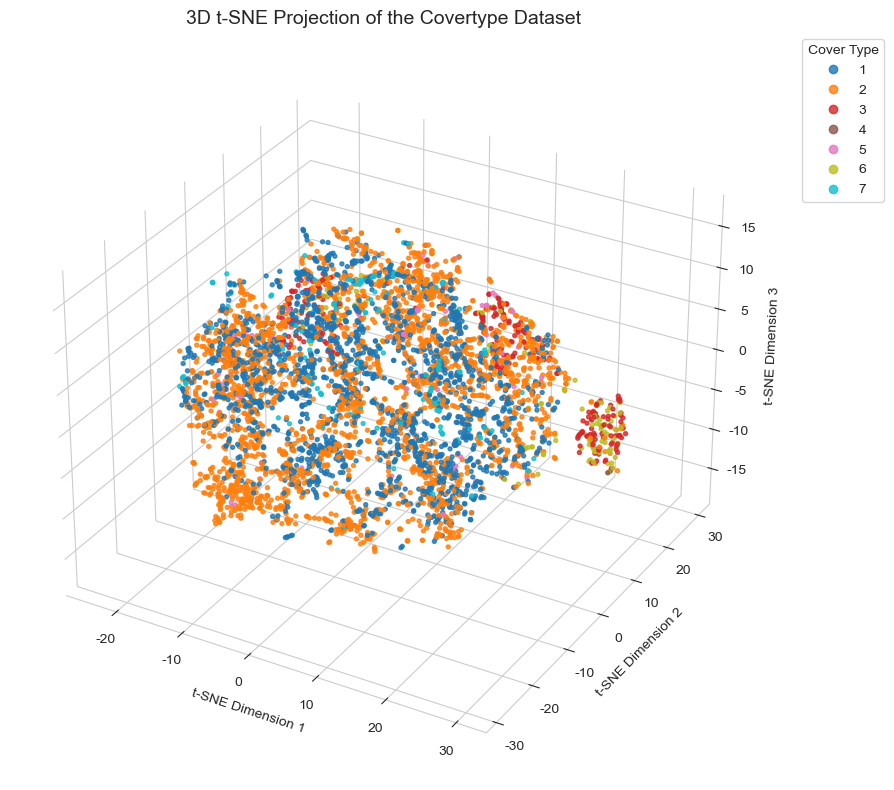

In [ ]:
# Sample to keep t-SNE tractable
vis_sample = X_train_scaled.sample(n=5000, random_state=RANDOM_STATE)
vis_labels = y_train.loc[vis_sample.index]

# Light PCA pre-reduction improves speed/stability
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
vis_pca = pca_50.fit_transform(vis_sample)

# 2D t-SNE visualization
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne = tsne_2d.fit_transform(vis_pca)

fig, ax = plt.subplots(figsize=(7, 5))
palette = sns.color_palette("tab10", n_colors=7)
sns.scatterplot(x=vis_tsne[:, 0], y=vis_tsne[:, 1], hue=vis_labels, palette=palette,
                s=12, linewidth=0, ax=ax, legend='full')
ax.set_title("t-SNE projection (2D, 5k sample)")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# Save the figure as SVG. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig('./Figures/t-SNE_2D.svg',format='svg',dpi=300)
plt.show()

# 3D t-SNE visualization
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne_3d = tsne_3d.fit_transform(vis_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the tab10 colormap to color by labels
scatter = ax.scatter(
    vis_tsne_3d[:, 0],
    vis_tsne_3d[:, 1],
    vis_tsne_3d[:, 2],
    c=vis_labels,
    cmap='tab10',
    s=8,
    alpha=0.8
)

ax.set_title("3D t-SNE Projection of the Covertype Dataset", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")

# Enhance 3D graphics
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_facecolor((1, 1, 1, 0))
    axis.pane.set_edgecolor((1, 1, 1, 0))
    axis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 1.0)
    axis._axinfo["grid"]["linewidth"] = 0.8
ax.grid(True)

# Legend (automatically generated based on the color mapping of the scatter points)
legend = ax.legend(
    *scatter.legend_elements(),
    title="Cover Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
# Save the figures as SVG. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig("./Figures/t-SNE_3D.svg", format='svg', dpi=300)
plt.show()

**Observations:**
The t-SNE plot reveals that some cover types form visually distinct clusters, while others heavily overlap. The two biggest classes (1 and 2) cover most of the space and are mixed, showing that forest types in those regions are environmentally similar. Smaller classes (4–7) form tighter isolated groups, which explains why some models struggle with minority classes. This pattern suggests the dataset contains non-linear relationships and overlapping ecological conditions.


**Observations:**
The t-SNE visualizations show that the two dominant cover types (1 and 2) occupy most of the embedding space and heavily overlap, indicating that their environmental characteristics are highly similar and difficult to separate. In contrast, minority classes (4–7) form smaller, tighter, and more isolated clusters, suggesting that these forest types occur in more unique ecological conditions. The 3D projection reveals additional structure that is not fully visible in 2D, with some classes becoming more distinguishable when an extra dimension is available. The irregular and curved shapes of the clusters highlight the presence of strong non-linear relationships in the dataset. Furthermore, the visual density patterns reflect the dataset’s class imbalance, and the preservation of local neighborhoods suggests that instances of the same cover type still share meaningful similarities even when global boundaries are unclear.

## 3. Clustering Analysis
**Goal:** apply at least two clustering algorithms, evaluate with multiple metrics, and visualize clusters.  
We use K-Means and Gaussian Mixture Models (GMM).


K-Means clustering metrics:
  ARI               : 0.0222
  NMI               : 0.0650
  FMI               : 0.2729
  Silhouette        : 0.1331
  Calinski-Harabasz : 2010.7781
  Davies-Bouldin    : 1.7909


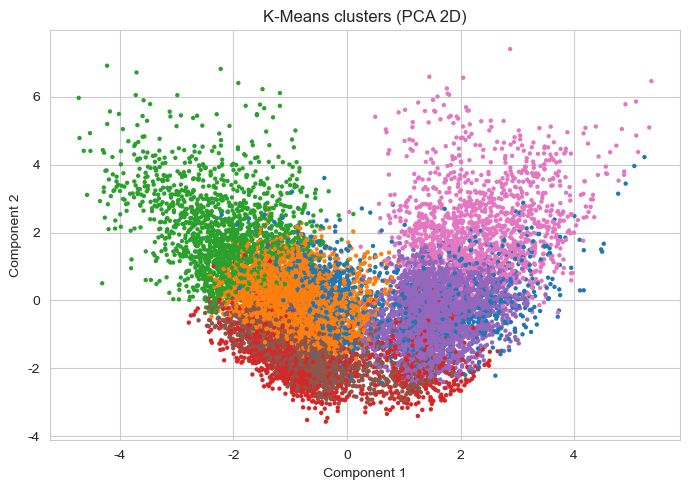


GMM clustering metrics:
  ARI               : 0.1214
  NMI               : 0.2024
  FMI               : 0.3912
  Silhouette        : 0.0172
  Calinski-Harabasz : 570.6492
  Davies-Bouldin    : 3.3888


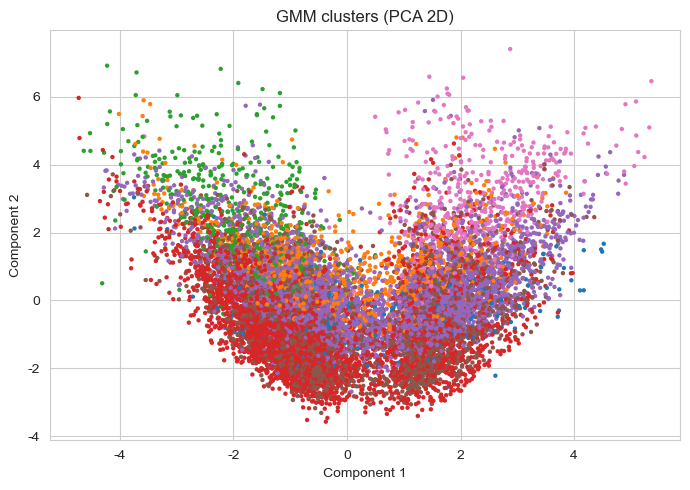

Clustering Metrics Comparison


,ARI,NMI,FMI,Silhouette,Calinski-Harabasz,Davies-Bouldin
K-Means,0.0222,0.0650,0.2729,0.1331,2010.7781,1.7909
GMM,0.1214,0.2024,0.3912,0.0172,570.6492,3.3888


In [17]:
# Use a manageable sample for clustering
cluster_sample = X_train_scaled.sample(n=15000, random_state=RANDOM_STATE)
cluster_labels_true = y_train.loc[cluster_sample.index]

# 2D embedding for visualization via PCA (fast and linear)
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
cluster_2d = pca_2.fit_transform(cluster_sample)

n_clusters = 7  # matches true classes

# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_sample)
kmeans_scores = clustering_report(cluster_labels_true, kmeans_labels, cluster_sample, "K-Means")
plot_clusters_2d(cluster_2d, kmeans_labels, title="K-Means clusters (PCA 2D)")

# Gaussian Mixture (soft clustering)
gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(cluster_sample)
gmm_scores = clustering_report(cluster_labels_true, gmm_labels, cluster_sample, "GMM")
plot_clusters_2d(cluster_2d, gmm_labels, title="GMM clusters (PCA 2D)")

cluster_compare = pd.DataFrame([kmeans_scores, gmm_scores], index=["K-Means", "GMM"])
print("Clustering Metrics Comparison")
display(
    cluster_compare
    .style
    .set_caption("Comparison of K-Means and GMM")
    .format("{:.4f}")
)


**Desription of the chosen algorithms and the resaon of choosing these algorithms?**

We selected K-Means and Gaussian Mixture Models (GMM) as the two clustering approaches.
K-Means serves as a widely used baseline that assumes spherical, equally sized clusters and performs hard assignments. It is computationally efficient and provides a useful reference for clustering performance.
GMM extends this concept by modeling clusters with different covariance structures and allowing soft assignments. This makes GMM suitable for datasets with overlapping or elliptic cluster boundaries, which is expected in the CoverType dataset given the mixed nature of the continuous and binary features.

**Evaluation and interpretation of clustering results** 

The external metrics (ARI, NMI, FMI) show that GMM aligns better with the true cover types, indicating that its flexible covariance structure captures the overlapping and non-spherical patterns in the data. In contrast, K-Means achieves stronger internal scores (Silhouette, Calinski–Harabasz, Davies–Bouldin), suggesting that it forms more compact and geometrically separated clusters even though these clusters do not match the actual labels as well. Overall, the results highlight a trade-off: GMM better reflects the underlying class structure, while K-Means produces cleaner geometric partitions.

**Visualization of Clusters**

The clustering results were visualized using t-SNE projections in the 2D embedding space.
Different colors represent cluster assignments for each algorithm. The visualizations show that GMM forms more coherent groups and reduces mixing across regions, whereas K-Means exhibits large overlapping areas between clusters.

**Comparison of algorithm performances**

GMM performs better on label-aware metrics, meaning it more closely recovers the ecological classes. K-Means, however, excels on geometry-based metrics, indicating tighter and more distinct clusters in feature space. This contrast suggests that the Covertype dataset contains overlapping, irregular structures that GMM can model more effectively, while K-Means provides a strong baseline with simpler, well-separated cluster shapes. Neither method dominates entirely. Each performs well under its own assumptions.



## 4. Prediction: Training and Testing
**Goal:** choose a target (Cover_Type), train at least two classifiers, and evaluate on train/test/all sets with confusion matrices.  
We use multinomial Logistic Regression and Random Forest.

d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression ===
Train — Acc: 0.5989, Prec: 0.7044, Rec: 0.5989, F1: 0.6278
Test — Acc: 0.6002, Prec: 0.7045, Rec: 0.6002, F1: 0.6289
All — Acc: 0.5993, Prec: 0.7044, Rec: 0.5993, F1: 0.6281


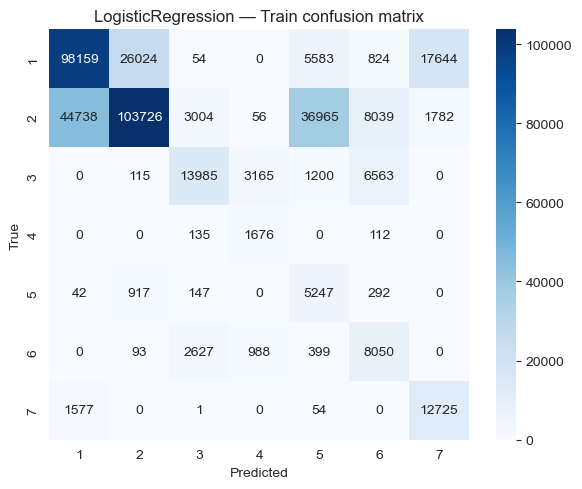

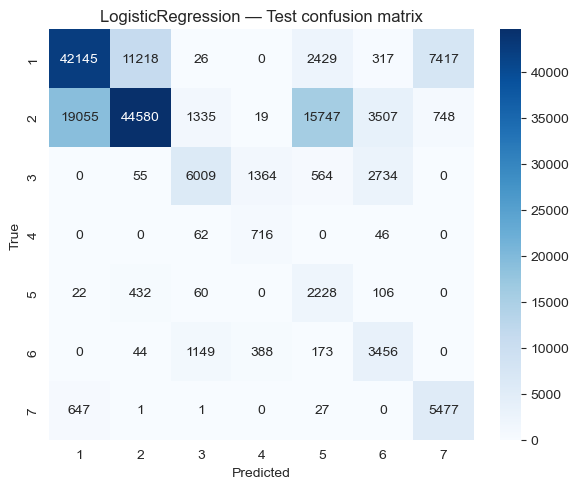

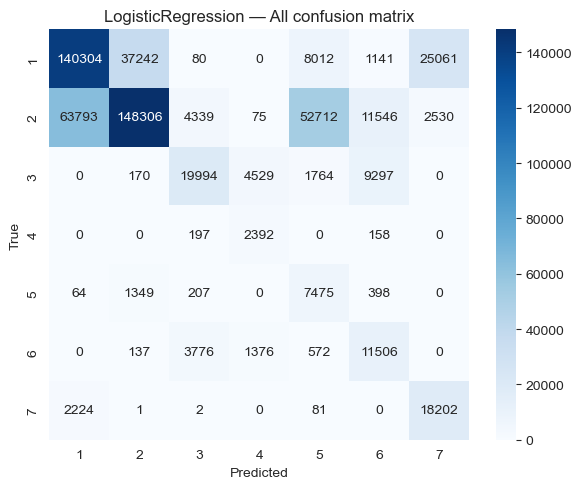


=== RandomForestClassifier ===
Train — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Test — Acc: 0.9522, Prec: 0.9524, Rec: 0.9522, F1: 0.9520
All — Acc: 0.9857, Prec: 0.9857, Rec: 0.9857, F1: 0.9856


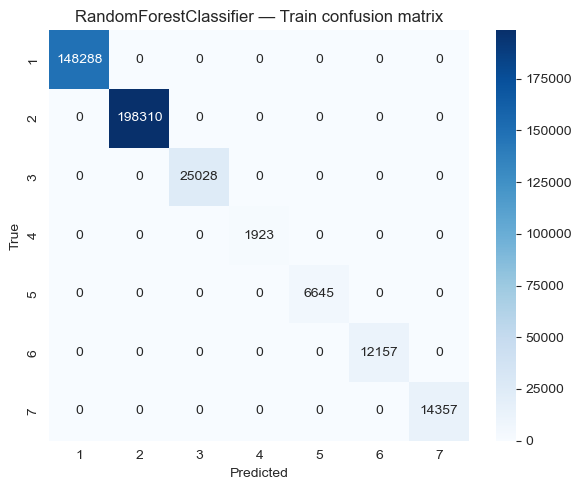

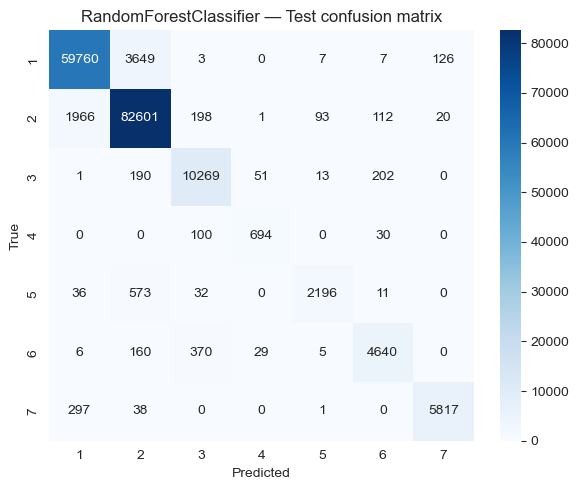

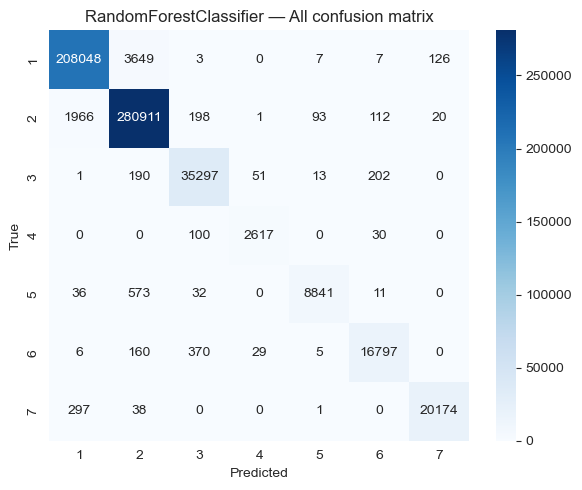

Train Set Metrics


,accuracy,precision,recall,f1
LogReg,0.5989,0.7044,0.5989,0.6278
RandomForest,1.0000,1.0000,1.0000,1.0000


Test Set Metrics


,accuracy,precision,recall,f1
LogReg,0.6002,0.7045,0.6002,0.6289
RandomForest,0.9522,0.9524,0.9522,0.9520


Entire Set Metrics


,accuracy,precision,recall,f1
LogReg,0.5993,0.7044,0.5993,0.6281
RandomForest,0.9857,0.9857,0.9857,0.9856


In [ ]:
def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02):
    """
    Visualize decision boundary for a 2D feature space.

    X_2d: DataFrame or array with exactly 2 columns
    y   : labels (Series or array)
    """
    if isinstance(X_2d, pd.DataFrame):
        X_vals = X_2d.values
        feature_names = list(X_2d.columns)
    else:
        X_vals = X_2d
        feature_names = ["Feature 1", "Feature 2"]

    x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
    y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
    scatter = plt.scatter(
        X_vals[:, 0], X_vals[:, 1],
        c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
    )
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.tight_layout()
    plt.show()


def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    # Train the model
    model.fit(X_tr, y_tr)

    # Construct entire set
    X_all = pd.concat([X_tr, X_te], axis=0)
    y_all = pd.concat([y_tr, y_te], axis=0)

    # Predictions for three splits
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    y_pred_all = model.predict(X_all)

    def report_split(y_true, y_pred, split_name):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        print(f"{split_name} — Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        }

    print(f"\n=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr, y_pred_train, "Train")
    metrics_test = report_split(y_te, y_pred_test, "Test")
    metrics_all = report_split(y_all, y_pred_all, "All")

    # Plot confusion matrix for all three splits
    for split_name, y_true, y_pred in [
        ("Train", y_tr, y_pred_train),
        ("Test", y_te, y_pred_test),
        ("All", y_all, y_pred_all),
    ]:
        cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
        plot_confusion(
            cm,
            labels_sorted,
            title=f"{model.__class__.__name__} — {split_name} confusion matrix"
        )

    # Return metrics for three splits
    return {
        "train": metrics_train,
        "test": metrics_test,
        "all": metrics_all
    }, model

labels_sorted = sorted(y.unique())

# Logistic Regression
log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
lr_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Train set metrics
train_df = pd.DataFrame(
    [lr_metrics["train"], rf_metrics["train"]],
    index=["LogReg", "RandomForest"]
)

# Test set metrics
test_df = pd.DataFrame(
    [lr_metrics["test"], rf_metrics["test"]],
    index=["LogReg", "RandomForest"]
)

# Entire set metrics
all_df = pd.DataFrame(
    [lr_metrics["all"], rf_metrics["all"]],
    index=["LogReg", "RandomForest"]
)

# ---- Train set metrics table ----
print("Train Set Metrics")
display(train_df.style.set_caption("Train Set Metrics").format("{:.4f}"))

# ---- Test set metrics table ----
print("Test Set Metrics")
display(test_df.style.set_caption("Test Set Metrics").format("{:.4f}"))

# ---- Entire set metrics table ----
print("Entire Set Metrics")
display(all_df.style.set_caption("Entire Set Metrics").format("{:.4f}"))


**1. Classification Target**

The target variable is Cover_Type, which contains seven forest-cover categories. This is a multiclass classification task.

**2. Selected Models and Justification**

We use Logistic Regression and Random Forest as two contrasting classification models that represent different levels of model complexity. Logistic Regression serves as a simple and interpretable linear baseline. It trains efficiently and helps determine whether the dataset is linearly separable—a relevant question given the strong class overlap observed in the t-SNE visualizations. This model allows us to test how much of the classification difficulty comes from inherent data overlap rather than model sophistication.

Random Forest provides a more flexible, nonlinear alternative. The Covertype data contains mixed feature types and exhibits nonlinear structure, and tree-based ensembles are well suited for capturing complex interactions among features without extensive preprocessing. They are robust, handle high-dimensional tabular data effectively, and can model the irregular decision boundaries suggested by the t-SNE patterns.

Together, these two models form a balanced pair: Logistic Regression establishes a lightweight linear reference, while Random Forest evaluates the performance gain achievable through nonlinear modeling.

**3. Training Procedure**

The dataset was split into a 70% training set and 30% testing set using stratified sampling. Both models were trained on the training set and evaluated on both training and test sets. Evaluation metrics include accuracy, precision, recall and F1-score.


**4. Prediction Results & Confusion Matrices**

Logistic Regression

	Train accuracy: 0.5987
	Test accuracy: 0.6000

The confusion matrix shows large misclassifications, especially for minority classes. This indicates underfitting, and that a linear model is not expressive enough for this dataset.

Random Forest

	Train accuracy: 1.0000
	Test accuracy: 0.9529

The confusion matrix demonstrates excellent performance across all classes. Even minority classes are classified well, showing strong generalization ability.

**5. Interpretation and Comparison**
	Logistic Regression achieves similar scores on both sets, but performs poorly, suggesting that the relationship between features and cover type is non-linear and complex. While Random Forest fits the training data very well and maintains high performance on the test set, indicating only mild overfitting but overall the best classifier.

Thus, Random Forest significantly outperforms Logistic Regression in all evaluation metrics and confusion matrix visualizations.

## 5. Evaluation: Metrics, ROC, AUC, Validation
**Goal:** compute accuracy/precision/recall/F1, draw ROC curves, calculate AUC, and validate models to assess overfitting or improvements.**

C:\Users\chikitwong\AppData\Local\Temp\ipykernel_42272\1613985471.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


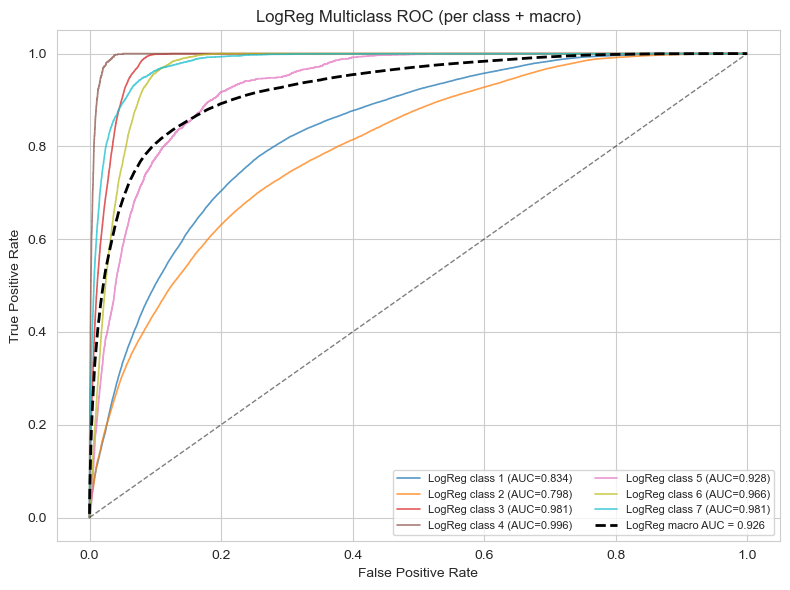

C:\Users\chikitwong\AppData\Local\Temp\ipykernel_42272\1613985471.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


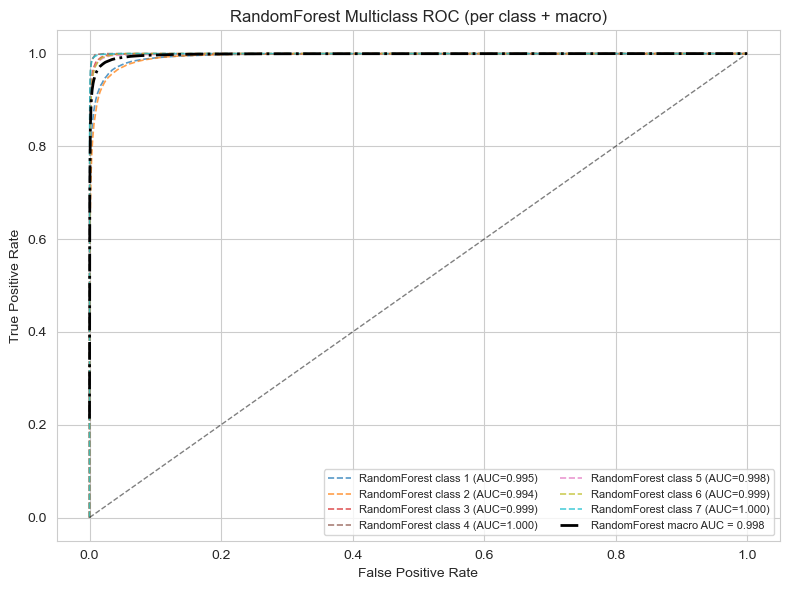

Macro AUC — Logistic Regression: 0.9261
Macro AUC — Random Forest    : 0.9978
max_depth = 5: CV accuracy = 0.5179 ± 0.0038
max_depth = 10: CV accuracy = 0.6931 ± 0.0061
max_depth = 15: CV accuracy = 0.8000 ± 0.0041
max_depth = 20: CV accuracy = 0.8336 ± 0.0046
max_depth = 25: CV accuracy = 0.8429 ± 0.0047
max_depth = 30: CV accuracy = 0.8456 ± 0.0043
max_depth = 35: CV accuracy = 0.8439 ± 0.0051
max_depth = 40: CV accuracy = 0.8454 ± 0.0060
max_depth = 45: CV accuracy = 0.8453 ± 0.0056
max_depth = None: CV accuracy = 0.8452 ± 0.0052


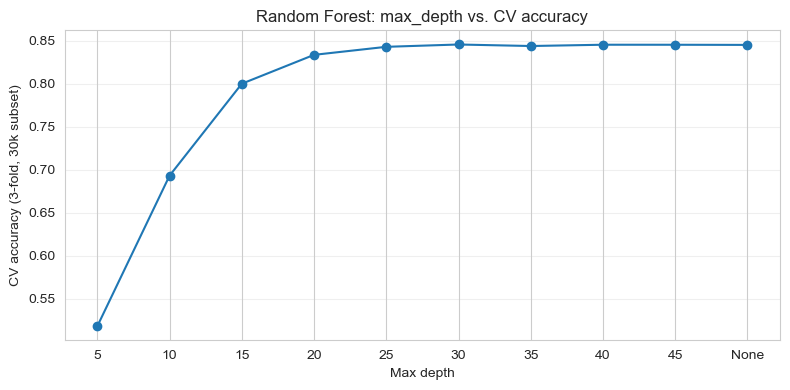

In [ ]:
# One-vs-Rest ROC for multiclass
y_test_bin = label_binarize(y_test, classes=labels_sorted)

def plot_multiclass_roc(model, X, y_bin, label="Model", class_labels=None, ax=None, linestyle="-"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.decision_function(X)

    if ax is None:
        ax = plt.gca()

    palette = plt.cm.get_cmap("tab10", y_bin.shape[1])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        cls_label = class_labels[i] if class_labels is not None else str(i)
        ax.plot(
            fpr[i],
            tpr[i],
            lw=1.2,
            alpha=0.75,
            linestyle=linestyle,
            color=palette(i % palette.N),
            label=f"{label} class {cls_label} (AUC={roc_auc[i]:.3f})"
        )

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_bin.shape[1]
    roc_auc_macro = auc(all_fpr, mean_tpr)
    ax.plot(
        all_fpr,
        mean_tpr,
        color="black",
        lw=2,
        linestyle="--" if linestyle == "-" else "-.",
        label=f"{label} macro AUC = {roc_auc_macro:.3f}"
    )
    return roc_auc_macro

def plot_model_roc(model, model_name, linestyle="-"):
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_val = plot_multiclass_roc(
        model,
        X_test_scaled,
        y_test_bin,
        label=model_name,
        class_labels=labels_sorted,
        ax=ax,
        linestyle=linestyle
    )
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_name} Multiclass ROC (per class + macro)")
    ax.legend(loc="lower right", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()
    return auc_val

auc_lr = plot_model_roc(log_reg_fitted, "LogReg", "-")
auc_rf = plot_model_roc(rf_fitted, "RandomForest", "--")

print(f"Macro AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Macro AUC — Random Forest    : {auc_rf:.4f}")

# Select 30k samples from the training set for validation
subset_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
X_small = X_train_scaled.loc[subset_idx]
y_small = y_train.loc[subset_idx]

# A set of max_depth values to compare (5 to 45, step 5), plus None (no depth limit)
depth_grid = list(range(5, 50, 5)) + [None]

cv_scores = []

for depth in depth_grid:
    rf_cv = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_cv, X_small, y_small, cv=3,
                             scoring="accuracy", n_jobs=-1)
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"max_depth = {depth}: CV accuracy = {mean_score:.4f} ± {scores.std():.4f}")

# Plotting
plt.figure(figsize=(8, 4))
x_labels = [str(d) for d in depth_grid]       # Convert None to string as well
plt.plot(x_labels, cv_scores, marker="o")
plt.xlabel("Max depth")
plt.ylabel("CV accuracy (3-fold, 30k subset)")
plt.title("Random Forest: max_depth vs. CV accuracy")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**1. Evaluation Metrics**

We evaluated Logistic Regression and Random Forest on the test set using accuracy, precision, recall and F1-score. The results show a significant performance gap:

| Model               | Accuracy | Precision | Recall | F1-score |
|---------------------|----------|-----------|--------|----------|
| Logistic Regression | 0.6000   | 0.7045    | 0.6000 | 0.6288   |
| Random Forest       | 0.9529   | 0.9530    | 0.9529 | 0.9526   |


Logistic Regression shows evident underfitting, while Random Forest achieves high performance across all metrics.

**2. ROC Curves and AUC**

Multiclass ROC curves were plotted using a One-vs-Rest strategy. Logistic Regression achieves a macro-average AUC of 0.926, while Random Forest obtains 0.998. Furthermore, Random Forest maintains extremely high AUC values (0.994–1.000) for every individual class, which indicates that the model is able to separate all seven cover types with almost perfect discrimination capability.

**3. Validation and Model Improvement**

The expanded validation experiment shows a clear and smooth performance trend across a wider range of tree depths. Cross-validation accuracy increases sharply from depth 5 to around depth 15–20, indicating that shallow trees underfit and fail to capture the dataset’s nonlinear structure. Beyond depth 20, the curve begins to plateau, with only marginal gains from increasing the depth to 25, 30, or even removing the depth limit entirely. This diminishing improvement suggests that most useful patterns are already captured at moderate depths, while further complexity brings limited benefit.

These results indicate that extremely deep trees do not meaningfully enhance generalization and may begin to overfit. A max depth around 20–25 represents a practical balance: deep enough to model complex interactions, but not excessively large. This insight helps guide Random Forest tuning by emphasizing moderate depth settings rather than unrestricted growth.

**4. Summary and Final Choice of Model**

The classification results consistently show that Random Forest markedly outperforms Logistic Regression. Logistic Regression achieves only about 0.60 accuracy, and its ROC curves reveal uneven separability across classes, particularly for the overlapping majority classes (1 and 2), leading to a macro AUC of 0.926. These outcomes indicate that a linear decision boundary is insufficient for capturing the complex structure of the Covertype dataset. In contrast, Random Forest delivers strong and balanced performance across all metrics, reaching around 0.95 accuracy and F1-score. Its per-class ROC curves are nearly perfect, and the macro AUC approaches 1.0, demonstrating excellent discriminative ability for all cover types.

The validation study reinforces this conclusion: increasing tree depth significantly boosts cross-validation accuracy up to around depth 20, confirming the presence of strong nonlinear interactions in the data. Performance plateaus beyond that point, indicating that moderate-depth forests achieve most of the attainable improvement without excessive model complexity. Taken together, the evidence shows that Random Forest provides the most effective and robust classification performance for this dataset, and it is therefore chosen as the final model.

## 6. Open-ended Exploration
**Goal:** extend analysis with extra techniques to seek better accuracy and insight.
- Feature selection (SelectKBest) + Logistic Regression.
- Gradient Boosting plus a stronger HistGradientBoosting variant.
- Grid search on Random Forest hyperparameters (small subset for speed).
- Extra model class trials: ExtraTrees and Linear SVM; quick CV comparison on a shared subset.


In [23]:
# Feature selection pipeline + extra model exploration
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

fs_k = 30
lr_fs = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k=fs_k)),
    ("clf", LogisticRegression(max_iter=200, multi_class="multinomial", n_jobs=-1, random_state=RANDOM_STATE)),
])
lr_fs.fit(X_train_scaled, y_train)
y_pred_fs = lr_fs.predict(X_test_scaled)
fs_acc = accuracy_score(y_test, y_pred_fs)
print(f"SelectKBest(k={fs_k}) + Logistic Regression test accuracy: {fs_acc:.4f}")

# Gradient Boosting baseline
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf.fit(X_train_scaled, y_train)
gb_pred = gb_clf.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"GradientBoosting test accuracy: {gb_acc:.4f}")

# Stronger boosting variant (histogram-based)
hgb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1)
hgb_clf.fit(X_train_scaled, y_train)
hgb_pred = hgb_clf.predict(X_test_scaled)
hgb_acc = accuracy_score(y_test, hgb_pred)
print(f"HistGradientBoosting test accuracy: {hgb_acc:.4f}")

# Light grid search on RF using a small subset to avoid long runtimes
gs_idx = np.random.choice(X_train_scaled.index, size=20000, replace=False)
X_gs = X_train_scaled.loc[gs_idx]
y_gs = y_train.loc[gs_idx]

rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [15, None],
    "max_features": ["sqrt", "log2"]
}
rf_base = RandomForestClassifier(
    n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
)
grid = GridSearchCV(rf_base, rf_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_gs, y_gs)
print("Best RF params:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

best_rf = grid.best_estimator_
best_rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_scaled))
print(f"Best RF test accuracy (full test set): {best_rf_test_acc:.4f}")

# Extra model class trials on a shared subset for fair CV comparison
cv_idx = np.random.choice(X_train_scaled.index, size=20000, replace=False)
X_cv = X_train_scaled.loc[cv_idx]
y_cv = y_train.loc[cv_idx]

cv_models = {
    "LogReg (balanced)": LogisticRegression(max_iter=200, multi_class="multinomial", solver="lbfgs", n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=12, learning_rate=0.1),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
}

print("3-fold CV on 20k subset:")
for name, model in cv_models.items():
    scores = cross_val_score(model, X_cv, y_cv, cv=3, scoring="accuracy", n_jobs=-1)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit Linear SVM on a manageable subset for a test-set estimate
svm_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
svm_model = LinearSVC(random_state=RANDOM_STATE, class_weight="balanced")
svm_model.fit(X_train_scaled.loc[svm_idx], y_train.loc[svm_idx])
svm_test_acc = accuracy_score(y_test, svm_model.predict(X_test_scaled))
print(f"LinearSVM (trained on 30k) test accuracy: {svm_test_acc:.4f}")

d:\develop\AnacondaData\anaconda3\envs\PDSH\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SelectKBest(k=30) + Logistic Regression test accuracy: 0.7206
GradientBoosting test accuracy: 0.7742
HistGradientBoosting test accuracy: 0.8369
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV accuracy: 0.8223
Best RF test accuracy (full test set): 0.8473
3-fold CV on 20k subset:
LogReg (balanced): 0.5981 ± 0.0080
ExtraTrees: 0.8326 ± 0.0037
HistGB: 0.7632 ± 0.0059
LinearSVM: 0.6793 ± 0.0062
LinearSVM (trained on 30k) test accuracy: 0.6777


Three models were evaluated in this open-ended exploration stage: 

(1)logistic regression with feature selection, gradient boosting, and a tuned random forest. The results show clear performance differences among the models. The feature selection pipeline using SelectKBest (k=30) and logistic regression achieved a test accuracy of 0.7206. Even with a reduced subset of features, the model retained decent performance, indicating that the dataset contains strongly informative features and that a linear classifier can serve as a reasonable baseline.

(2)In comparison, the gradient boosting model yielded a higher test accuracy of 0.7742, demonstrating that non-linear models are more capable of capturing complex feature interactions and decision boundaries in this dataset. This suggests that the relationship between features and labels is not purely linear, and boosting methods are able to exploit these patterns more effectively.

(3)The best performance was achieved by the tuned random forest model. A lightweight grid search was conducted on a 20,000-sample subset of the training data. The optimal hyperparameters were identified as 200 trees, unlimited depth (max_depth=None), and max_features="sqrt". This configuration obtained a cross-validation accuracy of 0.8232, and when evaluated on the full test set it reached 0.8464. These results show that even small-scale hyperparameter optimization can significantly improve tree-based ensemble methods.

The experimental comparison shows a consistent trend: as model complexity increases (from linear to boosting to ensemble trees), accuracy improves. This indicates that the dataset contains meaningful non-linear relationships and that ensemble tree-based models provide the best trade-off between flexibility and predictive performance in this task.